In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class StockDataset(Dataset):
    def __init__(self, data, lookback=20):
        self.lookback = lookback
        values = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
        self.X, self.y = [], []
        for i in range(len(values) - lookback):
            self.X.append(values[i:i+lookback])
            self.y.append(values[i+lookback, :3])  # predict Open, High, Close
        self.X, self.y = np.array(self.X), np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# ===================== Model =====================
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, output_size=3, num_layers=3, dropout=0.3):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])   # last hidden state + dropout
        out = self.fc(out)
        return out

# ===================== Training Function =====================
def train_model(model, train_loader, epochs=50, lr=0.001, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

        # Adaptive LR step
        scheduler.step(avg_loss)

    return model

# ===================== Main =====================
if __name__ == "__main__":
    # Load your dataset
    df = pd.read_csv("train_dataset1.csv")  # replace with your dataset
    lookback = 20

    dataset = StockDataset(df, lookback=lookback)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

    # Initialize model
    model = StockPredictor(
        input_size=5, hidden_size=128, output_size=3, num_layers=3, dropout=0.3
    )
    # Train model
    trained_model = train_model(model, train_loader, epochs=50, lr=0.001)
    # Save model
    torch.save(trained_model.state_dict(), "stock_predictor_dropout.pth")
    print("Model saved as stock_predictor_dropout.pth")

Epoch 1/50, Loss: 13461497856.000000
Epoch 2/50, Loss: 13407803392.000000
Epoch 3/50, Loss: 13423564800.000000
Epoch 4/50, Loss: 13397297664.000000
Epoch 5/50, Loss: 13417041920.000000
Epoch 6/50, Loss: 13447320576.000000
Epoch 7/50, Loss: 13433810944.000000
Epoch 8/50, Loss: 13428455936.000000
Epoch 9/50, Loss: 13406483968.000000
Epoch 10/50, Loss: 13446071808.000000
Epoch 11/50, Loss: 13447081472.000000
Epoch 12/50, Loss: 13443350528.000000
Epoch 13/50, Loss: 13392525312.000000
Epoch 14/50, Loss: 13405385728.000000
Epoch 15/50, Loss: 13460291584.000000
Epoch 16/50, Loss: 13427918336.000000
Epoch 17/50, Loss: 13423331840.000000
Epoch 18/50, Loss: 13404445696.000000
Epoch 19/50, Loss: 13388974080.000000
Epoch 20/50, Loss: 13477733888.000000
Epoch 21/50, Loss: 13465756160.000000
Epoch 22/50, Loss: 13399244800.000000
Epoch 23/50, Loss: 13431554560.000000
Epoch 24/50, Loss: 13391567360.000000
Epoch 25/50, Loss: 13415830528.000000
Epoch 26/50, Loss: 13411943936.000000
Epoch 27/50, Loss: 13

,Actual Open,Predicted Open,Actual High,Predicted High,Actual Close,Predicted Close
0,110652.164062,7.571837,111273.960938,7.906131,110574.765625,8.230819
1,110727.968750,7.571837,110949.914062,7.906131,110665.937500,8.230819
2,110795.421875,7.571837,110993.101562,7.906131,110028.703125,8.230819
3,110164.718750,7.571837,110301.140625,7.906131,110034.023438,8.230819
4,110256.164062,7.571837,110749.531250,7.906131,110229.953125,8.230819


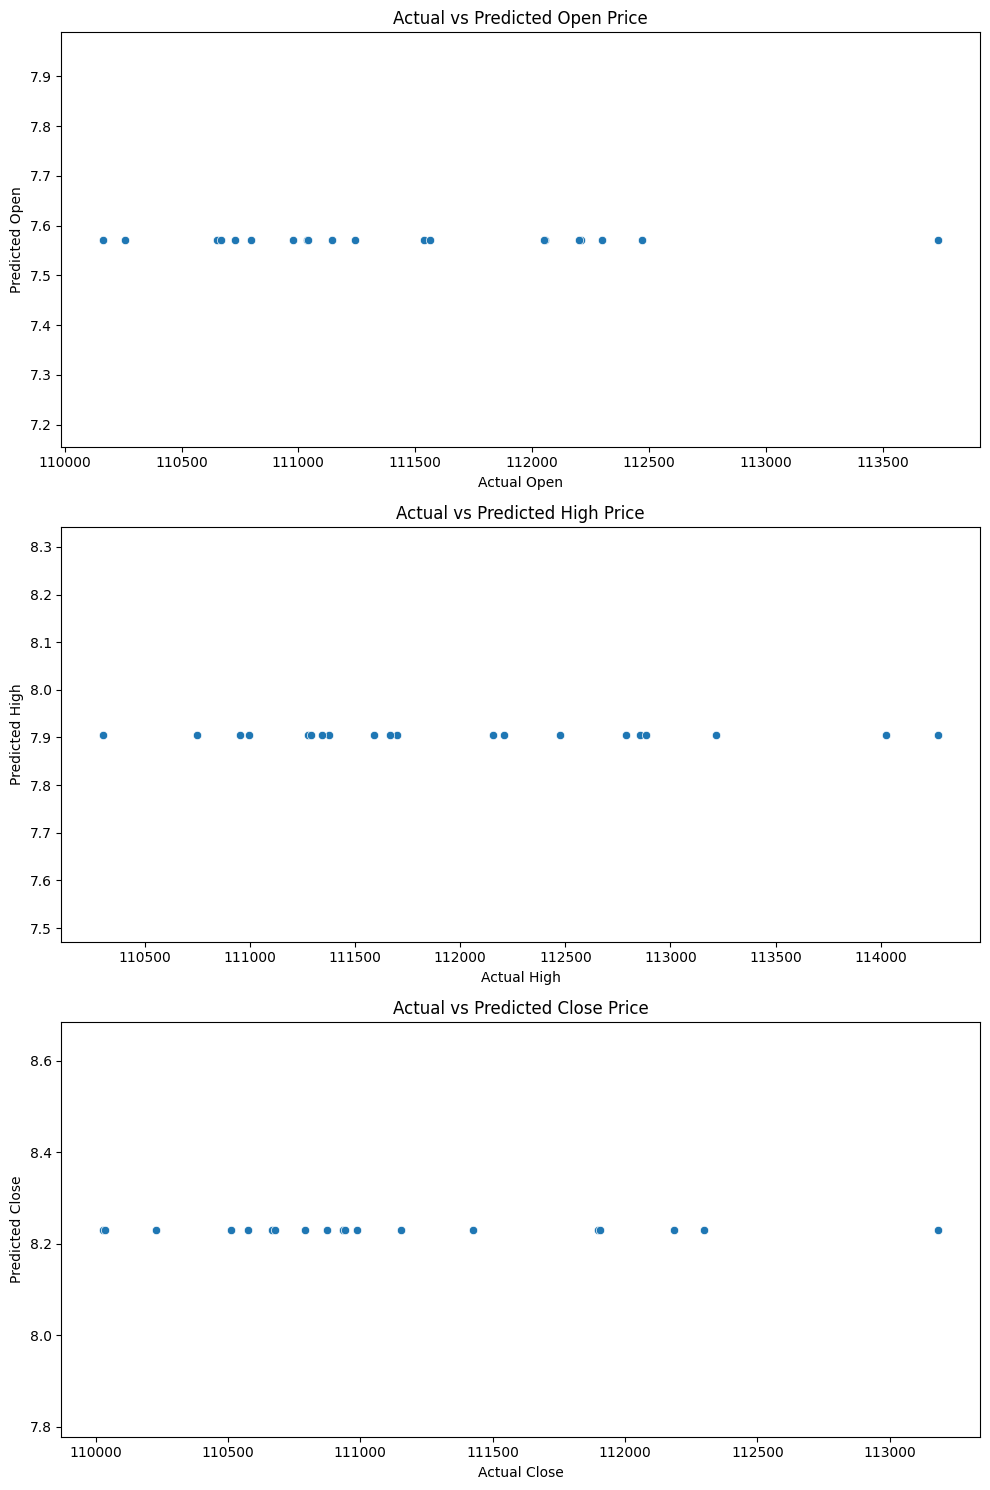

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ===================== Dataset =====================
class StockDataset(Dataset):
    def __init__(self, data, lookback=20):
        self.lookback = lookback
        values = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
        self.X, self.y = [], []
        for i in range(len(values) - lookback):
            self.X.append(values[i:i+lookback])
            self.y.append(values[i+lookback, :3])  # predict Open, High, Close
        self.X, self.y = np.array(self.X), np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# ===================== Model =====================
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, output_size=3, num_layers=3, dropout=0.3):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])   # last hidden state + dropout
        out = self.fc(out)
        return out

# Load the test dataset
# Replace "test_dataset.csv" with the actual path to your test data
try:
    df_test = pd.read_csv("test_dataset1.csv")
except FileNotFoundError:
    print("Error: test_dataset.csv not found. Please provide a test dataset.")
    # You might want to handle this error more gracefully, e.g., by using a portion of the training data for testing
    # For now, we'll stop here if the file is not found
    exit()

# Create a test dataset and DataLoader
lookback = 20 # Define lookback as it's used in StockDataset
test_dataset = StockDataset(df_test, lookback=lookback)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the trained model
model = StockPredictor(
    input_size=5, hidden_size=128, output_size=3, num_layers=3, dropout=0.3
)
model.load_state_dict(torch.load("stock_predictor_dropout.pth"))
model.eval() # Set the model to evaluation mode

# Make predictions
predictions = []
actuals = []
with torch.no_grad():
    for X, y in test_loader:
        preds = model(X)
        predictions.extend(preds.numpy())
        actuals.extend(y.numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Actual Open': actuals[:, 0],
    'Predicted Open': predictions[:, 0],
    'Actual High': actuals[:, 1],
    'Predicted High': predictions[:, 1],
    'Actual Close': actuals[:, 2],
    'Predicted Close': predictions[:, 2],
})

display(plot_df.head())

# Plotting actual vs predicted values for Open, High, and Close
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.scatterplot(x='Actual Open', y='Predicted Open', data=plot_df, ax=axes[0])
axes[0].set_title('Actual vs Predicted Open Price')

sns.scatterplot(x='Actual High', y='Predicted High', data=plot_df, ax=axes[1])
axes[1].set_title('Actual vs Predicted High Price')

sns.scatterplot(x='Actual Close', y='Predicted Close', data=plot_df, ax=axes[2])
axes[2].set_title('Actual vs Predicted Close Price')

plt.tight_layout()
plt.show()

Epoch 1/50, Train Loss: 0.369253, Val Loss: 0.309461
Epoch 2/50, Train Loss: 0.300194, Val Loss: 0.276347
Epoch 3/50, Train Loss: 0.291546, Val Loss: 0.240710
Epoch 4/50, Train Loss: 0.290301, Val Loss: 0.200278
Epoch 5/50, Train Loss: 0.220862, Val Loss: 0.152230
Epoch 6/50, Train Loss: 0.160357, Val Loss: 0.095537
Epoch 7/50, Train Loss: 0.101744, Val Loss: 0.043554
Epoch 8/50, Train Loss: 0.051786, Val Loss: 0.084983
Epoch 9/50, Train Loss: 0.081888, Val Loss: 0.085912
Epoch 10/50, Train Loss: 0.079413, Val Loss: 0.047951
Epoch 11/50, Train Loss: 0.044731, Val Loss: 0.033072
Epoch 12/50, Train Loss: 0.036593, Val Loss: 0.037474
Epoch 13/50, Train Loss: 0.052948, Val Loss: 0.044775
Epoch 14/50, Train Loss: 0.050081, Val Loss: 0.049748
Epoch 15/50, Train Loss: 0.050698, Val Loss: 0.051228
Epoch 16/50, Train Loss: 0.058855, Val Loss: 0.049363
Epoch 17/50, Train Loss: 0.060153, Val Loss: 0.044959
Epoch 18/50, Train Loss: 0.055088, Val Loss: 0.042116
Epoch 19/50, Train Loss: 0.052100, Va

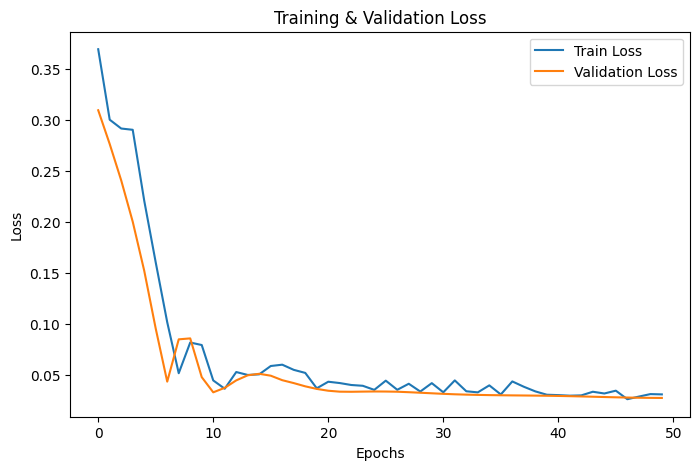

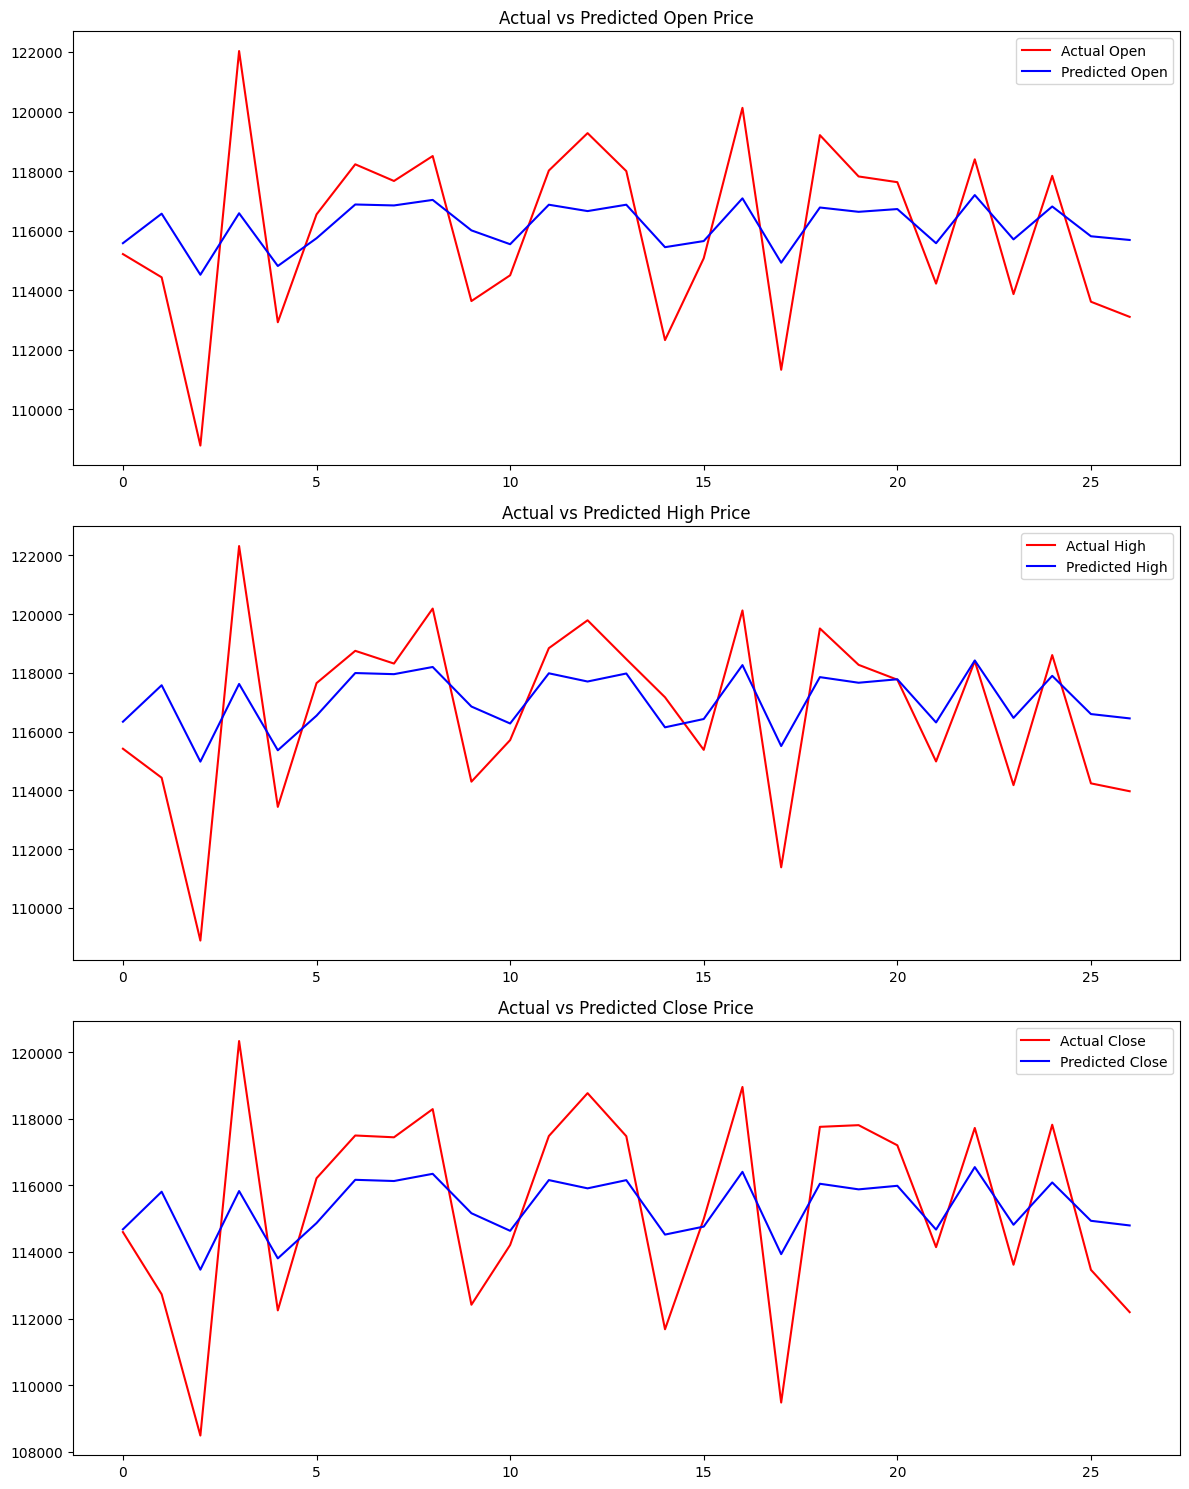

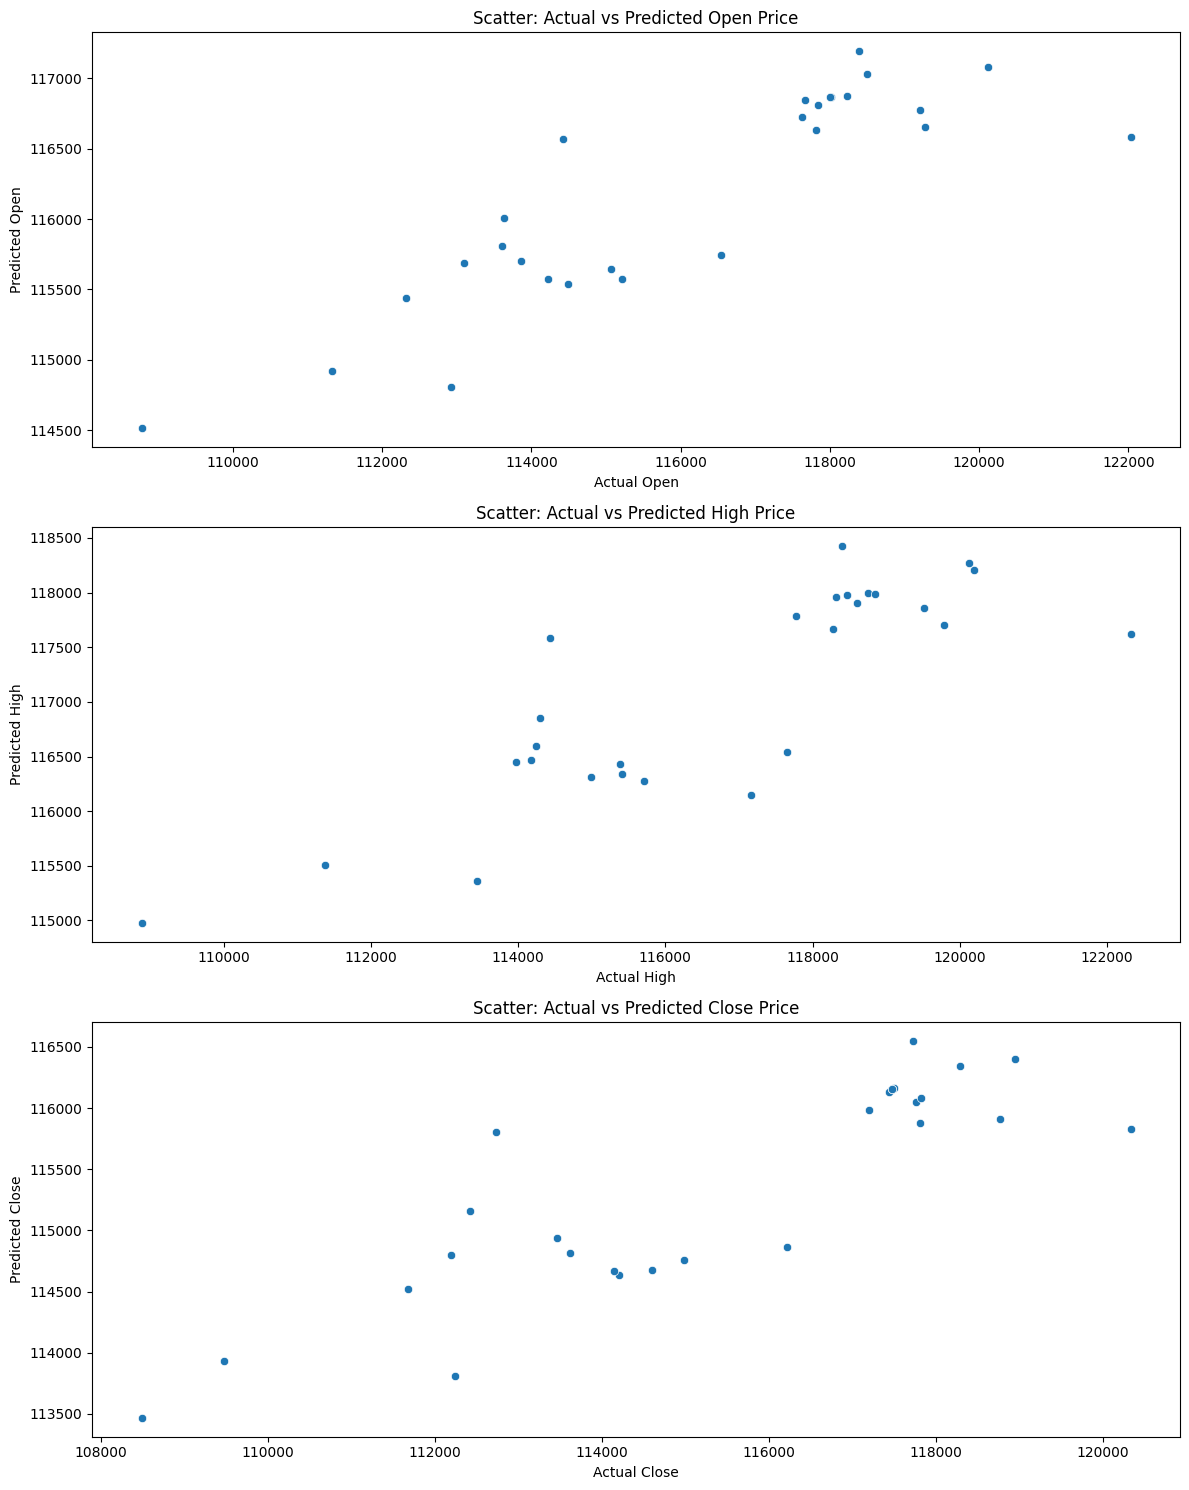

In [9]:
class StockDataset(Dataset):
    def __init__(self, data, lookback=20):
        self.lookback = lookback
        values = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
        self.X, self.y = [], []
        for i in range(len(values) - lookback):
            self.X.append(values[i:i+lookback])
            self.y.append(values[i+lookback, :3])  # predict Open, High, Close
        self.X, self.y = np.array(self.X), np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# ===================== Model =====================
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, output_size=3, num_layers=3, dropout=0.3):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])   # last hidden state + dropout
        out = self.fc(out)
        return out

# ===================== Training Function =====================
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    train_losses, val_losses = [], []
    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        scheduler.step(avg_val_loss)

    return model, train_losses, val_losses

# ===================== Main =====================
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv("train_dataset1.csv")  # Replace with your dataset
    lookback = 20

    # Scale data
    scaler = MinMaxScaler()
    df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

    dataset = StockDataset(df, lookback=lookback)

    # Split train/val/test
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model
    model = StockPredictor()
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=50)

    # Save model + scaler
    torch.save(model.state_dict(), "stock_predictor_full.pth")
    print("✅ Model saved as stock_predictor_full.pth")

    # -------- Loss Plot --------
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    # -------- Predictions --------
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X, y in test_loader:
            preds = model(X)
            predictions.extend(preds.numpy())
            actuals.extend(y.numpy())

    predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((len(predictions),2))]))[:, :3]
    actuals = scaler.inverse_transform(np.hstack([actuals, np.zeros((len(actuals),2))]))[:, :3]

    plot_df = pd.DataFrame({
        "Actual Open": actuals[:, 0],
        "Predicted Open": predictions[:, 0],
        "Actual High": actuals[:, 1],
        "Predicted High": predictions[:, 1],
        "Actual Close": actuals[:, 2],
        "Predicted Close": predictions[:, 2],
    })

    # -------- Line Plots --------
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    axes[0].plot(plot_df["Actual Open"].values, label="Actual Open", color="red")
    axes[0].plot(plot_df["Predicted Open"].values, label="Predicted Open", color="blue")
    axes[0].set_title("Actual vs Predicted Open Price")
    axes[0].legend()

    axes[1].plot(plot_df["Actual High"].values, label="Actual High", color="red")
    axes[1].plot(plot_df["Predicted High"].values, label="Predicted High", color="blue")
    axes[1].set_title("Actual vs Predicted High Price")
    axes[1].legend()

    axes[2].plot(plot_df["Actual Close"].values, label="Actual Close", color="red")
    axes[2].plot(plot_df["Predicted Close"].values, label="Predicted Close", color="blue")
    axes[2].set_title("Actual vs Predicted Close Price")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # -------- Scatter Plots --------
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    sns.scatterplot(x="Actual Open", y="Predicted Open", data=plot_df, ax=axes[0])
    axes[0].set_title("Scatter: Actual vs Predicted Open Price")

    sns.scatterplot(x="Actual High", y="Predicted High", data=plot_df, ax=axes[1])
    axes[1].set_title("Scatter: Actual vs Predicted High Price")

    sns.scatterplot(x="Actual Close", y="Predicted Close", data=plot_df, ax=axes[2])
    axes[2].set_title("Scatter: Actual vs Predicted Close Price")

    plt.tight_layout()
    plt.show()

Epoch 1/50, Train Loss: 0.345158, Val Loss: 0.335297
Epoch 2/50, Train Loss: 0.294485, Val Loss: 0.303875
Epoch 3/50, Train Loss: 0.276513, Val Loss: 0.270271
Epoch 4/50, Train Loss: 0.249117, Val Loss: 0.231680
Epoch 5/50, Train Loss: 0.229159, Val Loss: 0.184631
Epoch 6/50, Train Loss: 0.190892, Val Loss: 0.125906
Epoch 7/50, Train Loss: 0.144879, Val Loss: 0.059122
Epoch 8/50, Train Loss: 0.076814, Val Loss: 0.030111
Epoch 9/50, Train Loss: 0.049321, Val Loss: 0.076068
Epoch 10/50, Train Loss: 0.093557, Val Loss: 0.058835
Epoch 11/50, Train Loss: 0.068745, Val Loss: 0.032686
Epoch 12/50, Train Loss: 0.048910, Val Loss: 0.028201
Epoch 13/50, Train Loss: 0.043434, Val Loss: 0.036863
Epoch 14/50, Train Loss: 0.056418, Val Loss: 0.045670
Epoch 15/50, Train Loss: 0.049936, Val Loss: 0.051309
Epoch 16/50, Train Loss: 0.055454, Val Loss: 0.052010
Epoch 17/50, Train Loss: 0.052084, Val Loss: 0.049110
Epoch 18/50, Train Loss: 0.067677, Val Loss: 0.042925
Epoch 19/50, Train Loss: 0.048383, Va

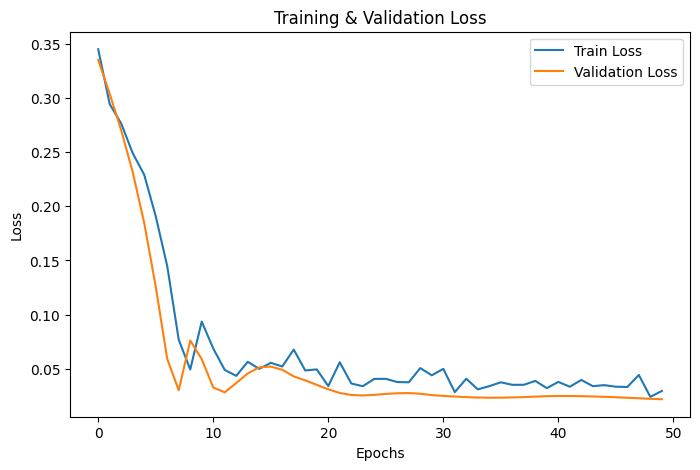

Open: RMSE = 2115.7469, R² = 0.3773
High: RMSE = 2105.2921, R² = 0.4423
Close: RMSE = 2236.4483, R² = 0.3834


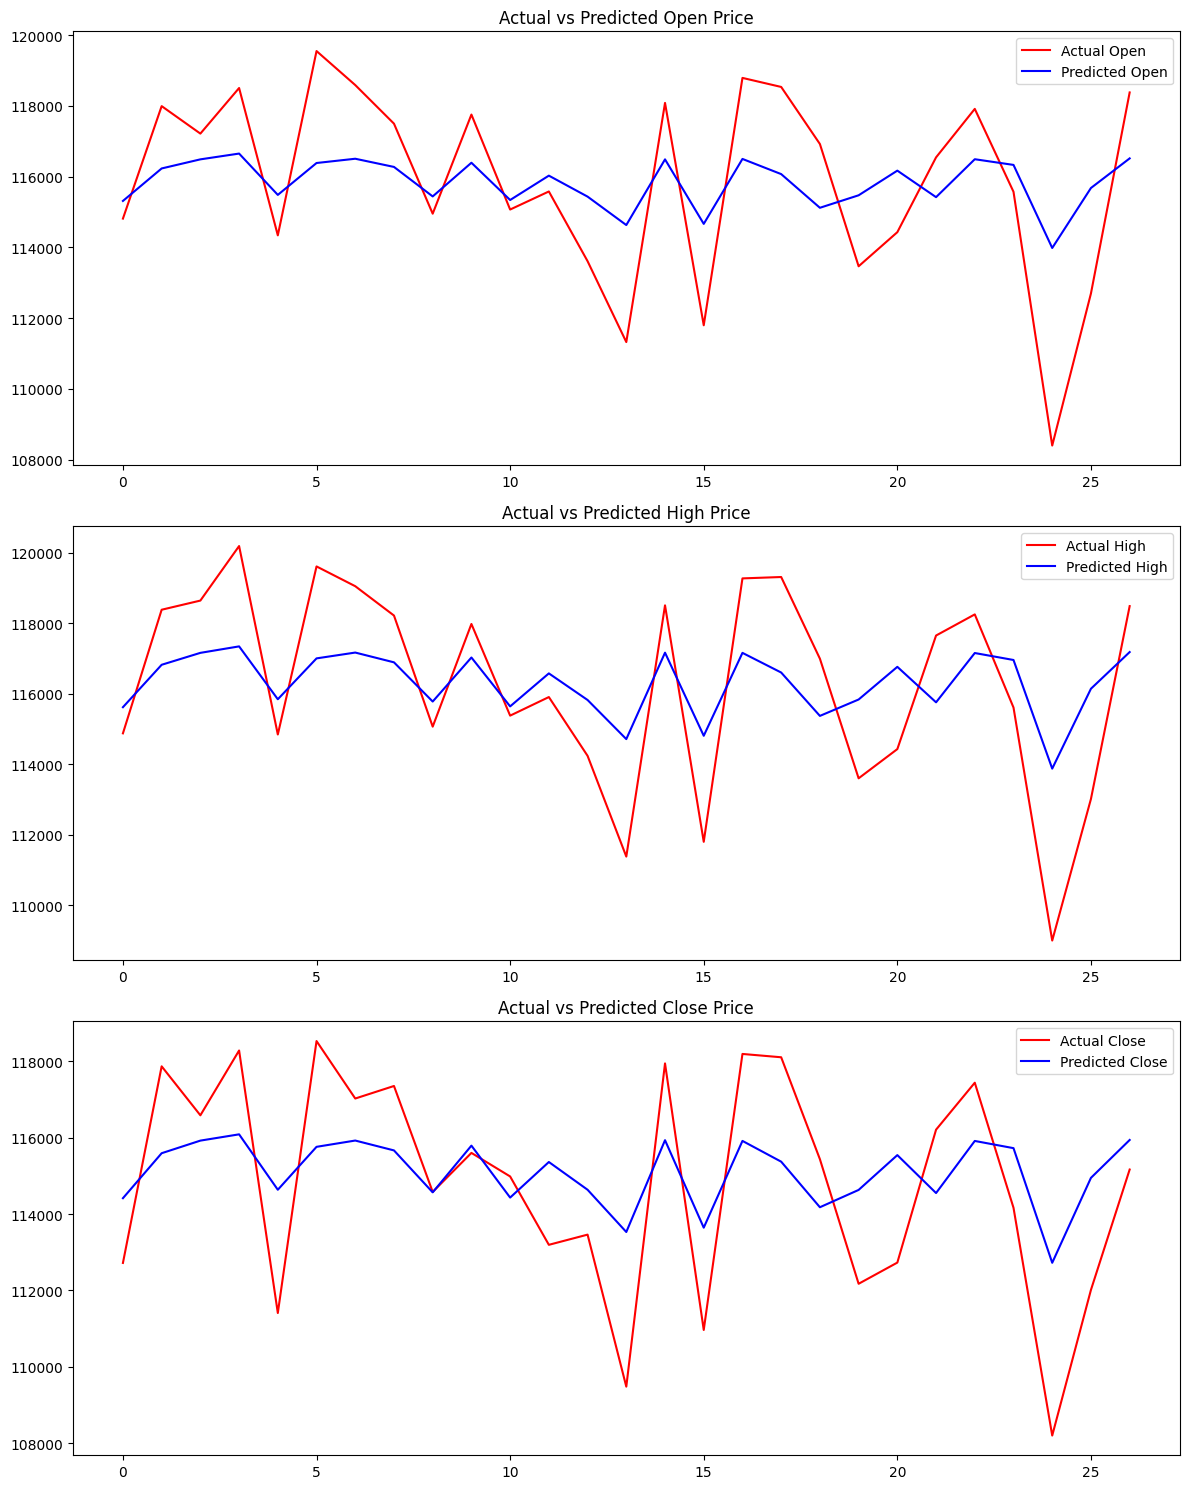

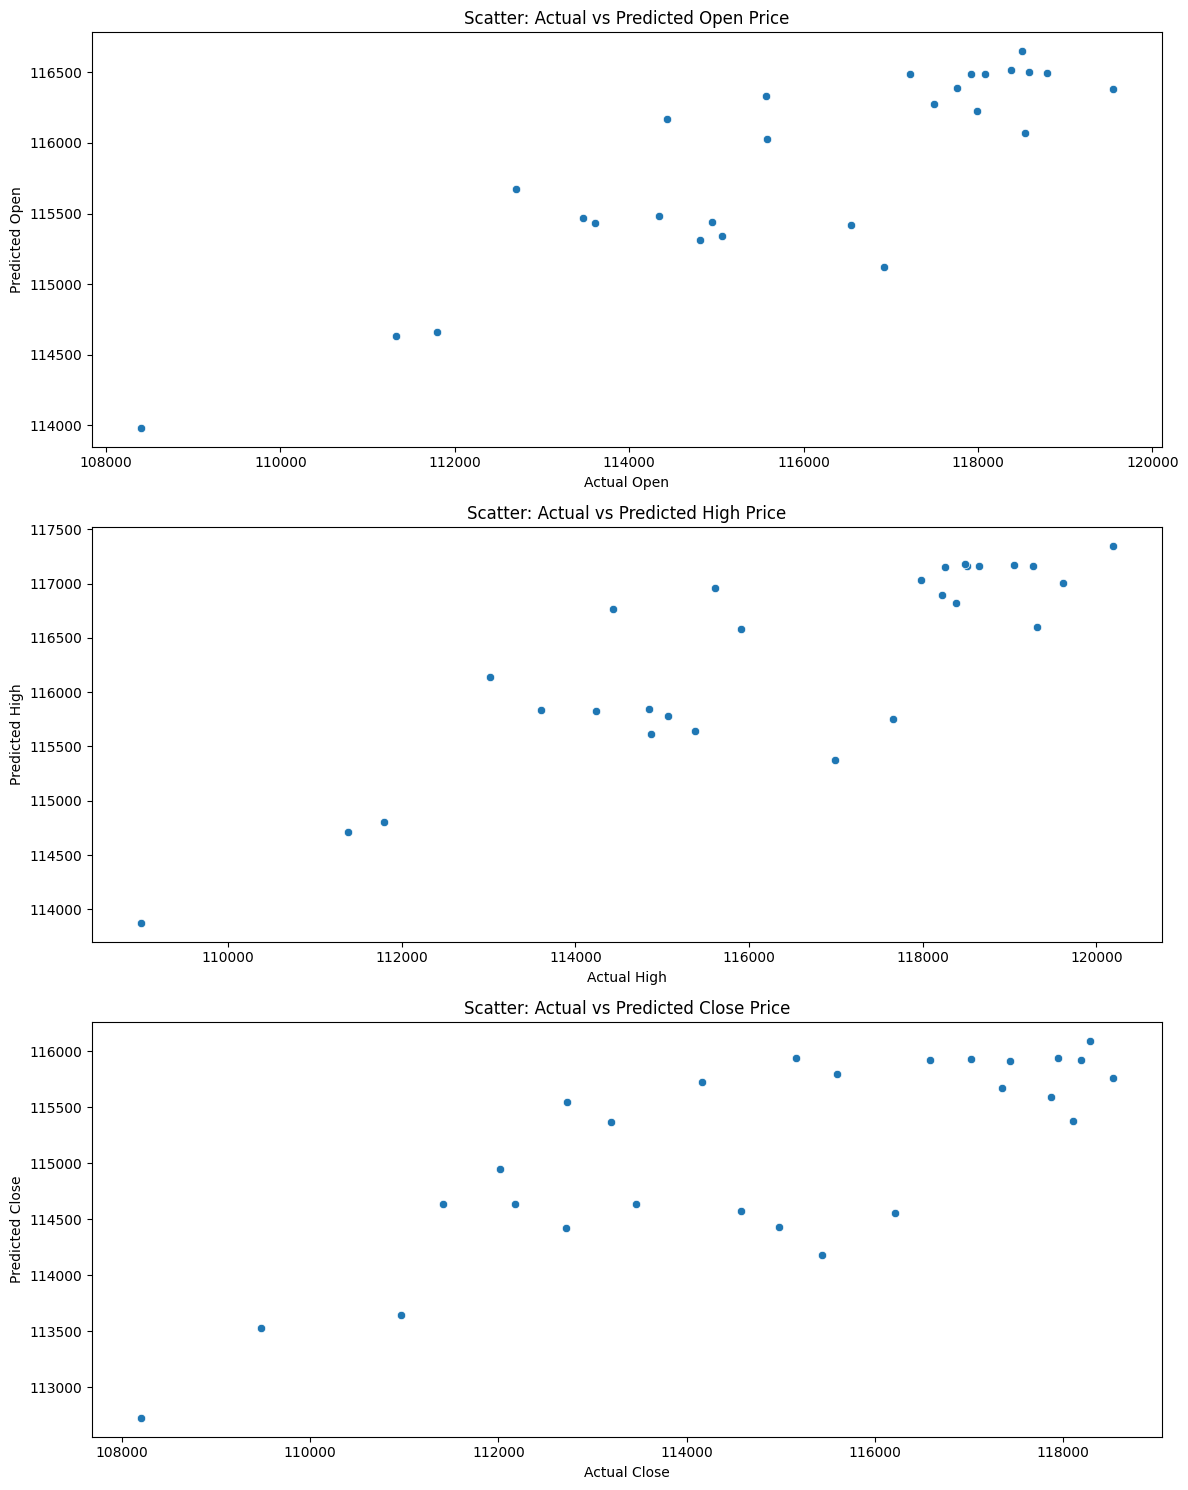

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== Dataset =====================
class StockDataset(Dataset):
    def __init__(self, data, lookback=20):
        self.lookback = lookback
        values = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
        self.X, self.y = [], []
        for i in range(len(values) - lookback):
            self.X.append(values[i:i+lookback])
            self.y.append(values[i+lookback, :3])  # predict Open, High, Close
        self.X, self.y = np.array(self.X), np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# ===================== Model =====================
class StockPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, output_size=3, num_layers=3, dropout=0.3):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])   # last hidden state + dropout
        out = self.fc(out)
        return out

# ===================== Training Function =====================
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    train_losses, val_losses = [], []
    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
        scheduler.step(avg_val_loss)

    return model, train_losses, val_losses

# ===================== Main =====================
if __name__ == "__main__":
    # Load dataset
    df = pd.read_csv("stock_data.csv")  # Replace with your dataset
    lookback = 20

    # Scale data
    scaler = MinMaxScaler()
    df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

    dataset = StockDataset(df, lookback=lookback)

    # Split train/val/test
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model
    model = StockPredictor()
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=50)

    # Save model + scaler
    torch.save(model.state_dict(), "stock_predictor_full.pth")
    print("✅ Model saved as stock_predictor_full.pth")

    # -------- Loss Plot --------
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    # -------- Predictions --------
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X, y in test_loader:
            preds = model(X)
            predictions.extend(preds.numpy())
            actuals.extend(y.numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Inverse transform (pad missing columns for scaler)
    predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((len(predictions),2))]))[:, :3]
    actuals = scaler.inverse_transform(np.hstack([actuals, np.zeros((len(actuals),2))]))[:, :3]

    plot_df = pd.DataFrame({
        "Actual Open": actuals[:, 0],
        "Predicted Open": predictions[:, 0],
        "Actual High": actuals[:, 1],
        "Predicted High": predictions[:, 1],
        "Actual Close": actuals[:, 2],
        "Predicted Close": predictions[:, 2],
    })

    # -------- Metrics --------
    for i, col in enumerate(["Open", "High", "Close"]):
        rmse = np.sqrt(mean_squared_error(plot_df[f"Actual {col}"], plot_df[f"Predicted {col}"]))
        r2 = r2_score(plot_df[f"Actual {col}"], plot_df[f"Predicted {col}"])
        print(f"{col}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

    # -------- Line Plots --------
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    for i, col in enumerate(["Open", "High", "Close"]):
        axes[i].plot(plot_df[f"Actual {col}"].values, label=f"Actual {col}", color="red")
        axes[i].plot(plot_df[f"Predicted {col}"].values, label=f"Predicted {col}", color="blue")
        axes[i].set_title(f"Actual vs Predicted {col} Price")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # -------- Scatter Plots --------
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    for i, col in enumerate(["Open", "High", "Close"]):
        sns.scatterplot(x=f"Actual {col}", y=f"Predicted {col}", data=plot_df, ax=axes[i])
        axes[i].set_title(f"Scatter: Actual vs Predicted {col} Price")
    plt.tight_layout()
    plt.show()
